In [47]:
%load_ext autoreload
%autoreload 2

import os
import random
from abc import abstractmethod
from os.path import join as oj
from tqdm import tqdm
from typing import Dict

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Memory
import seaborn as sns
from sklearn.neighbors import KernelDensity   
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from rulevetting.projects.tbi_pecarn.dataset import Dataset
from rulevetting.projects.tbi_pecarn import helper
from rulevetting.projects.tbi_pecarn import graph

# Set plotting font sizes and properties
TINY_SIZE = 12
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20
MARKER_SIZE = 6
LINE_SIZE = 4

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=TINY_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("lines", markersize=MARKER_SIZE)  # marker size
plt.rc("lines", linewidth=LINE_SIZE)  # line width

mpl.rcParams["figure.dpi"] = 180

# Height and width per row and column of subplots
FIG_HEIGHT = 20
FIG_WIDTH = 18

fig_fcn = lambda kwargs: plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT), **kwargs)
color_list = sns.color_palette("colorblind")

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
# loading in the data - edit below path
data_path = '/Users/marko/rule-vetting/data'
df = Dataset().clean_data(data_path = data_path)

Reading the raw CSVs... ['TBI PUD 10-08-2013.csv', 'TBI PUD Imaging.csv', 'TBI PUD Neuro.csv']


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.48it/s]


In [5]:
print(len(df.columns.tolist()))
print(len(df))

125

/Users/marko/rule-vetting/rule-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Fraction of Missingness'>

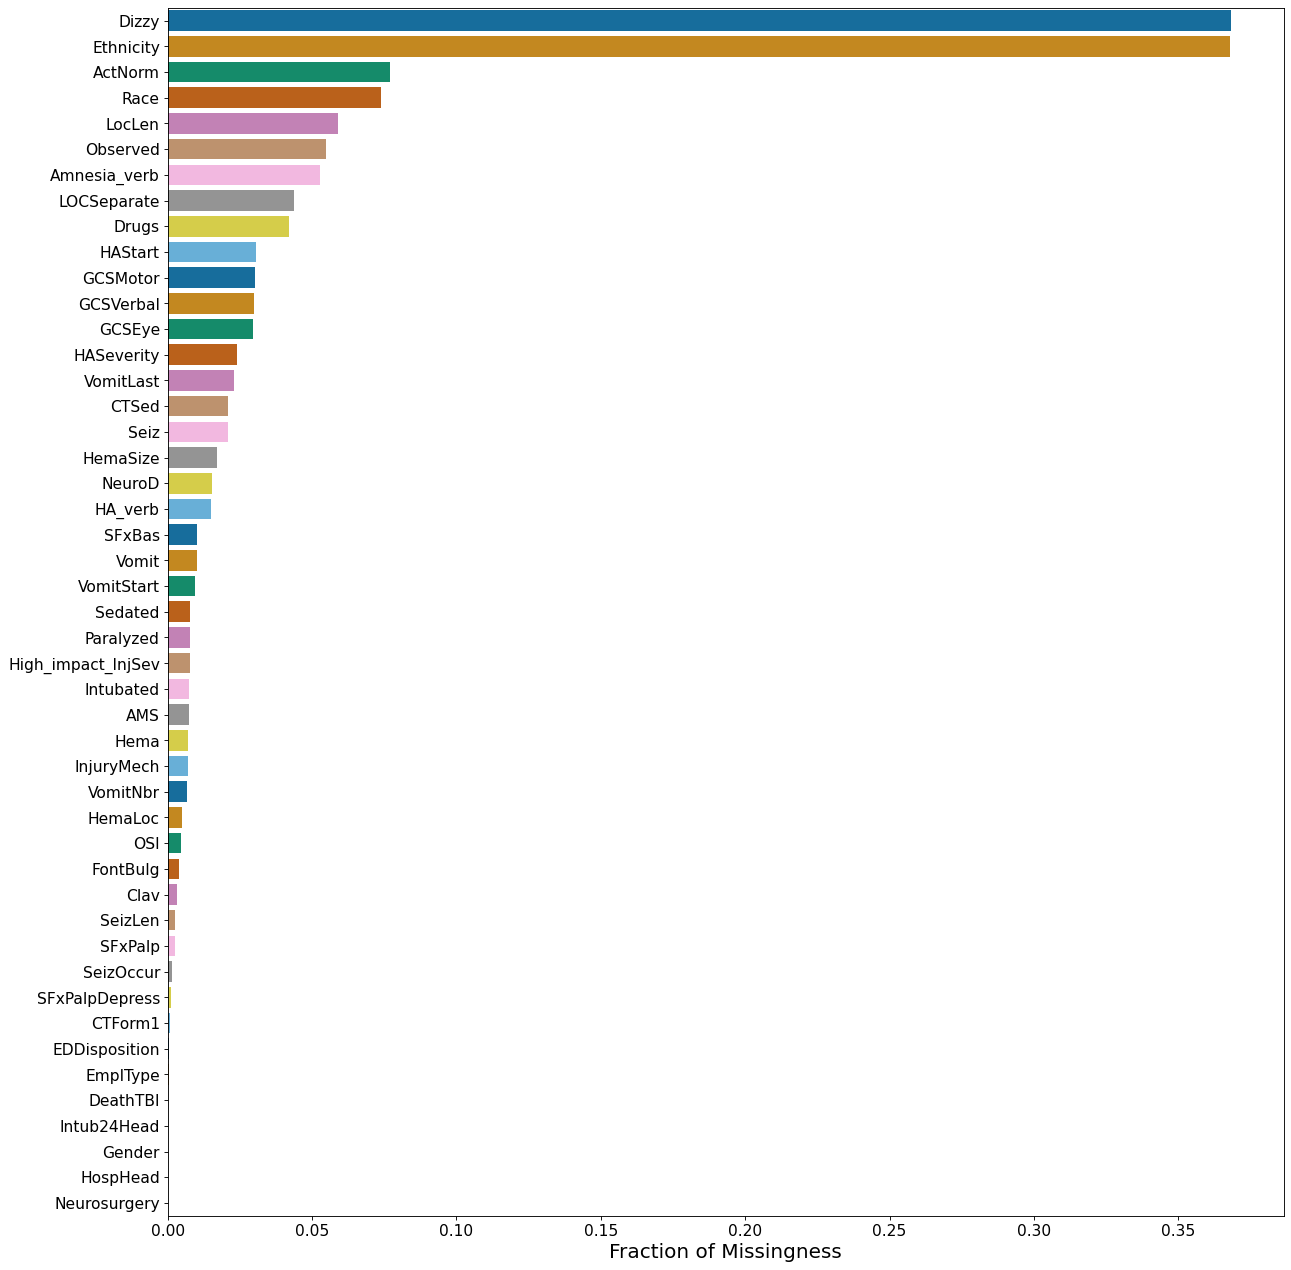

In [48]:
pd.set_option('display.max_columns', 100)
na_col_counts = df.apply(lambda col: (col == 'Unknown').mean())
na_col_counts = na_col_counts[na_col_counts > 0]
na_col_counts = na_col_counts.sort_values(ascending=False)
graph.barplot(na_col_counts, 
        True, 
        None,
        "Fraction of Missingness"
)

The above plot shows dizziness and ethnicity as the two most missing features by far. I assume as the GCS score is 14-15, that dizziness is implied and so maybe it's skipped over in the form but for ethnicity I'm not sure but race does not have the same % missing. <insert other stuff about this here to deal with>...

From the 'TBI PUD 10-08-2013.csv', there seem to be 20 patients without the outcome variable PosIntFinal. However in the frequencies of categorical variables, the union of missing Intub24Head, Neurosurgery, HospHeadPosCT, and DeathTBI is 1 which means at most 1 of the 20 cannot be inferred from these. As seen below, it turns out that we can infer all of these outcomes which results in no missing outcomes from our data set.  

In [33]:
def infer_missing_outcome(row):
    outcome = 'Unknown'
    # look at known outcome columns to infer outcome
    not_missing = [data for data in row if data != 'Unknown']
    
    # if all values that are known give the same answer, use that as the outcome
    if len(not_missing) > 0 and not_missing.count(not_missing[0]) == len(not_missing):
        outcome = not_missing[0]
    return outcome

outcome_vars = ['HospHeadPosCT', 'Intub24Head', 'Neurosurgery', 'DeathTBI']
df.loc[df['PosIntFinal'] == 'Unknown', 'PosIntFinal'] = df[df['PosIntFinal'] == 'Unknown'][outcome_vars].apply(infer_missing_outcome, axis=1)

Now we can pivot to see if similar analysis can be applied to our features. I first noticed HospHead has 3 missing values while HospHeadPosCT which is the intersection of HospHead and TBI on CT which has zero missing values. These all yield no however alongside PosCT which can imply HospHead was occured but there was no TBI on CT - hence we leave it as is.

In [708]:
df.loc[df['HospHead'] == 'Unknown', ['HospHead', 'PosCT', 'HospHeadPosCT']] 

,HospHead,PosCT,HospHeadPosCT
75,Unknown,No,No
9541,Unknown,No,No
42815,Unknown,No,No


To decide if there are entire columns we would want to remove, it may prove luxuriant to examine the distribution of missing values per observation - as seen below, the 25-75th percentile averages around 7-16 missing columns whereas there are a plethora on the high end - we'll find out which ones these are and if they need to be removed.

Text(0, 0.5, 'Distribution of Rows')

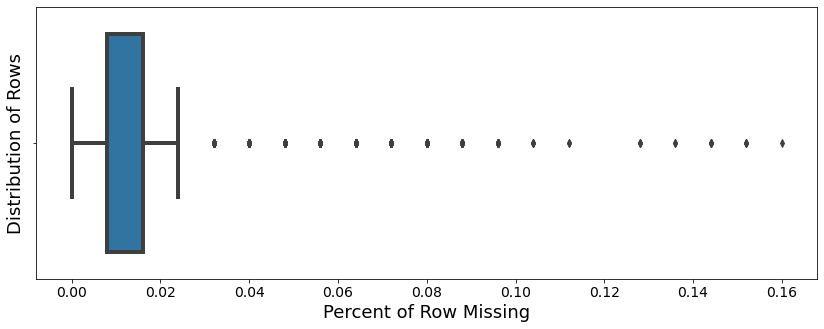

In [709]:
# plotting distribution of missing values per each row of the main data set
X = df.apply(lambda col: (col == 'Unknown').sum() / len(col), axis=1).to_numpy().reshape(-1, 1)
fig, ax = plt.subplots(figsize=(14, 5))
sns.boxplot(x=X)
plt.xlabel('Percent of Row Missing')
plt.ylabel('Distribution of Rows')

Here we can look at our only two/three features that aren't categorical and get a better sense of the distribution - sns uses a Gaussian kde I believe as default.

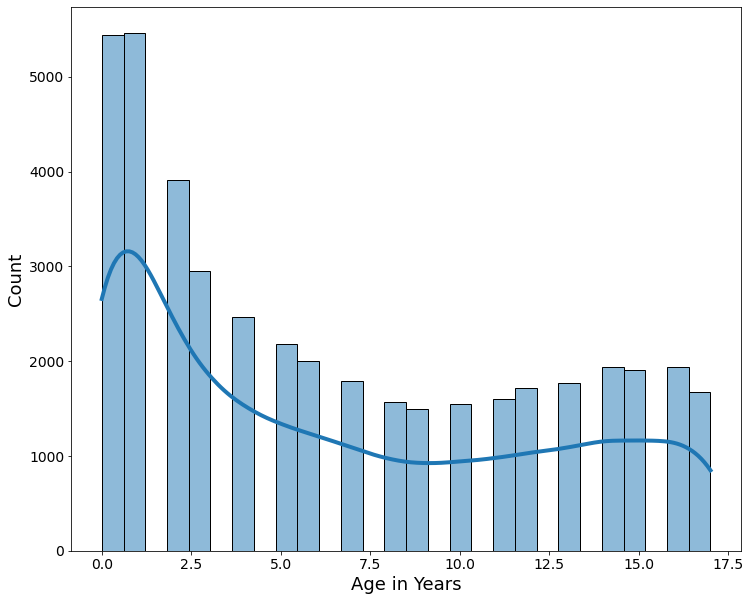

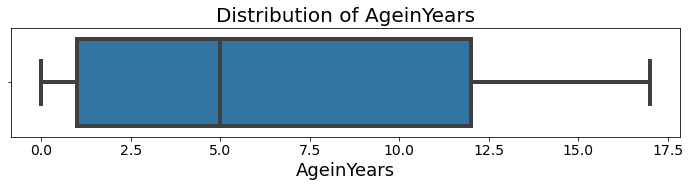

In [49]:
# looking at the distributions of data - this is a pseudo function - change top params
dist_plot = True
boxplot_plot = True
feature = 'AgeinYears'
title = f'Distribution of {feature}'

if dist_plot:
    fig, ax = plt.subplots(figsize=(12,10))
    sns.histplot(data=df, x=feature, kde=True)
    plt.xlabel("Age in Years")
    plt.savefig("figs/" + f"age_dist.png", dpi=350)

if boxplot_plot:
    fig, ax = plt.subplots(figsize=(12,2))
    ax.set_title(title)
    plt.xlabel("Age in Years")
    ax = sns.boxplot(data=df, x=feature)


Here we look at "parent" features and analyze which ones are no and the subsequent questions are not applicable - we can infer these. 

In [22]:
def frac_no_not_applicable(df, feat, subfeats):
    # df - dataframe
    # feat - string of feature with subfeatues - example vomit, seiz, ...
    # subfeats - those subfeatures - vomitnbr, etc.
    # return fraction of those subfeats that are not applicable and parent var is no
    for subfeat in subfeats:
        print(f'{feat} and {subfeat}')
        print(len(df[(df[feat] == 'No') & (df[subfeat] == 'Not applicable')]) / len(df[df[feat] == 'No']))
        
# loc vars
frac_no_not_applicable(df, 'LOCSeparate', ['LocLen'])

# seiz vars
frac_no_not_applicable(df, 'Seiz', ['SeizOccur', 'SeizLen'])

# ha vars
frac_no_not_applicable(df, 'HA_verb', ['HASeverity', 'HAStart'])

# vomit vars
frac_no_not_applicable(df, 'Vomit', ['VomitNbr', 'VomitStart', 'VomitLast'])

# ams vars
frac_no_not_applicable(df, 'AMS', ['AMSAgitated', 'AMSSleep', 'AMSSlow', 'AMSRepeat', 'AMSOth'])

# sfx vars
frac_no_not_applicable(df, 'SFxPalp', ['SFxPalpDepress'])

# sfxbas vars
frac_no_not_applicable(df, 'SFxBas', ['SFxBasHem', 'SFxBasHem', 'SFxBasOto', 'SFxBasPer', 'SFxBasRet', 'SFxBasRhi'])

# hema vars
frac_no_not_applicable(df, 'Hema', ['HemaLoc', 'HemaSize'])

# clav vars
frac_no_not_applicable(df, 'Clav', ['ClavFace', 'ClavNeck', 'ClavFro', 'ClavOcc', 'ClavPar', 'ClavTem'])

LOCSeparate and LocLen
1.0
Seiz and SeizOccur
1.0
Seiz and SeizLen
1.0
HA_verb and HASeverity
1.0
HA_verb and HAStart
1.0
Vomit and VomitNbr
1.0
Vomit and VomitStart
1.0
Vomit and VomitLast
1.0
AMS and AMSAgitated
1.0
AMS and AMSSleep
1.0
AMS and AMSSlow
1.0
AMS and AMSRepeat
1.0
AMS and AMSOth
1.0
SFxPalp and SFxPalpDepress
1.0
SFxBas and SFxBasHem
1.0
SFxBas and SFxBasHem
1.0
SFxBas and SFxBasOto
1.0
SFxBas and SFxBasPer
1.0
SFxBas and SFxBasRet
1.0
SFxBas and SFxBasRhi
1.0
Hema and HemaLoc
1.0
Hema and HemaSize
1.0
Clav and ClavFace
1.0
Clav and ClavNeck
1.0
Clav and ClavFro
1.0
Clav and ClavOcc
1.0
Clav and ClavPar
1.0
Clav and ClavTem
1.0


Now is a good time before continuing EDA to partition the data into train, validation, and a test set to not bias our model selection a priori observing the distributions and correlations.

In [50]:
# remove post-ct vars and examine relationships with outcome variable
df1 = df.copy()
df1 = df1[df1['PosIntFinal'] != 'Unknown']
df1.rename(columns = {'PosIntFinal':'outcome'}, inplace=True)
df1 = df1.drop(columns=Dataset().get_post_ct_names())

Below we see the strongest features in terms of absolute correlation to the outcome. There are notable features that are implicitly defined as the outcome such as deathTBI which is part of the outcome so we'd expect such a strong correlation to exist. Other noteworthy features include several of the unknowns/missing one-hot encoded features which means maybe we can infer from somewhere else how this implies the patient does or does not have ciTBI...

/Users/marko/rule-vetting/rule-env/lib/python3.9/site-packages/numpy/lib/arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/marko/rule-vetting/rule-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Outcome Correlation')

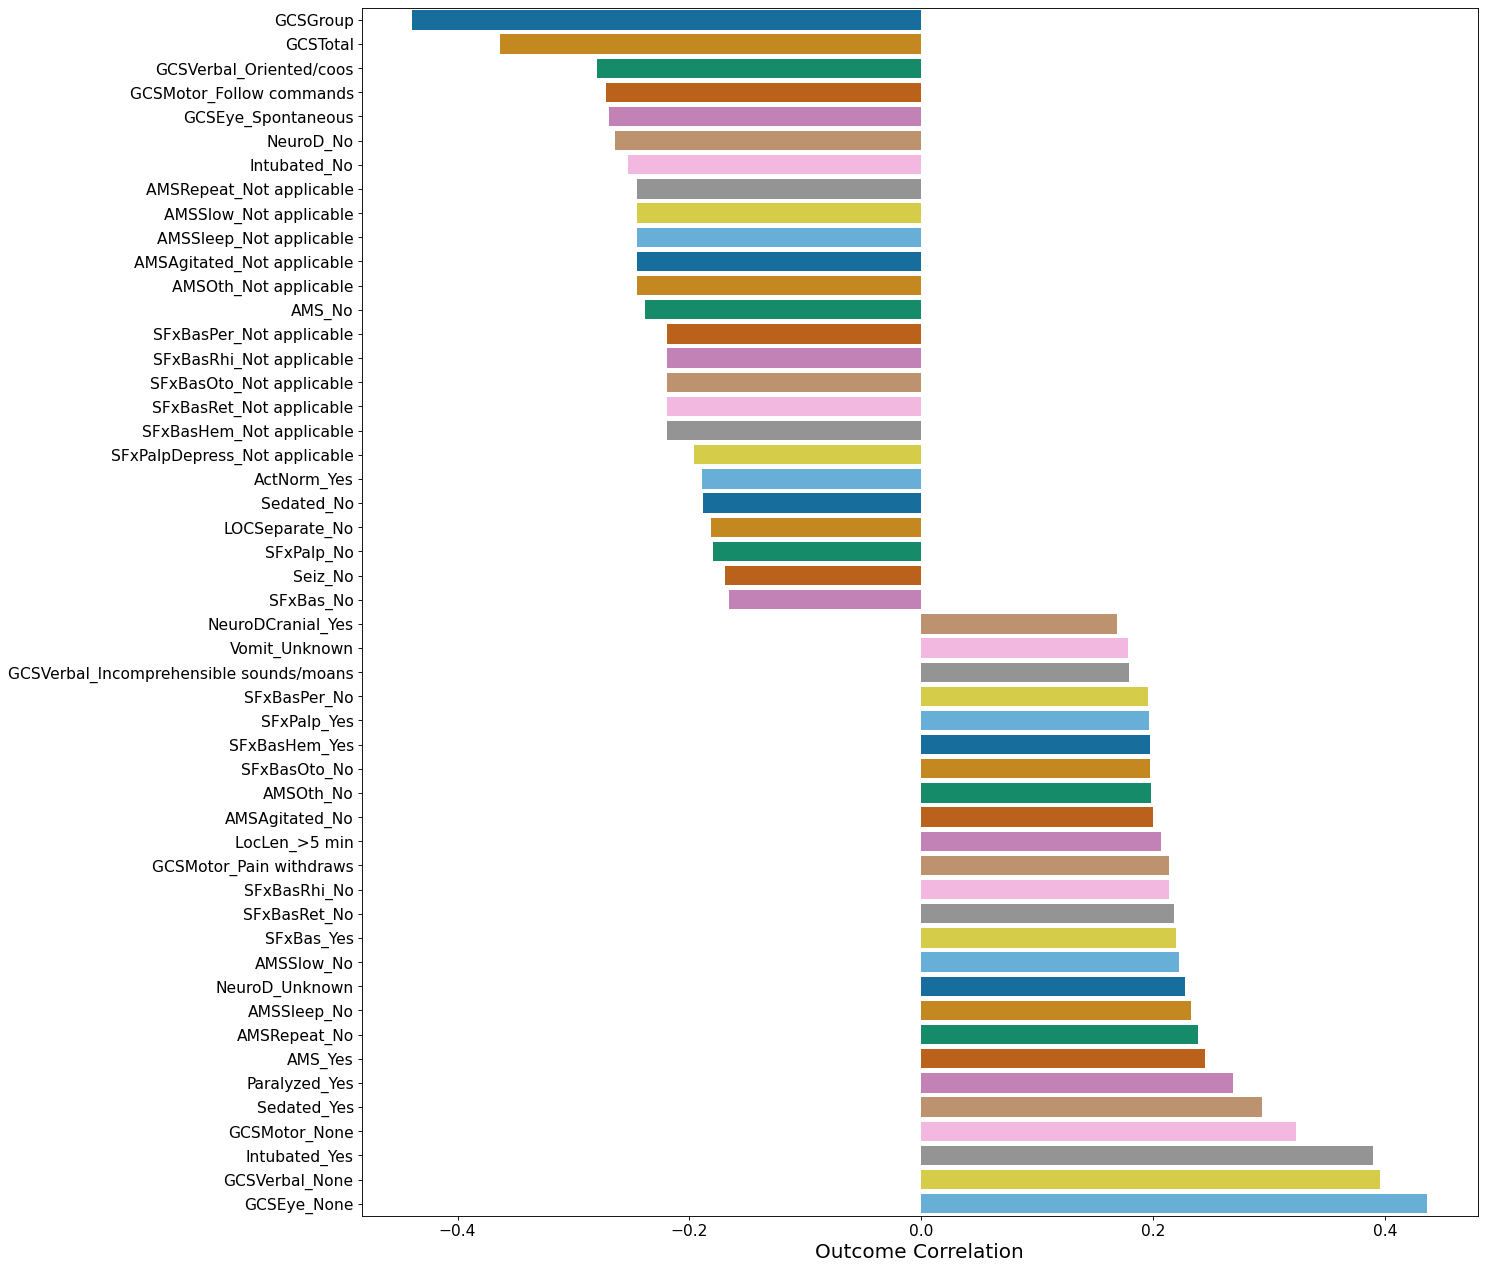

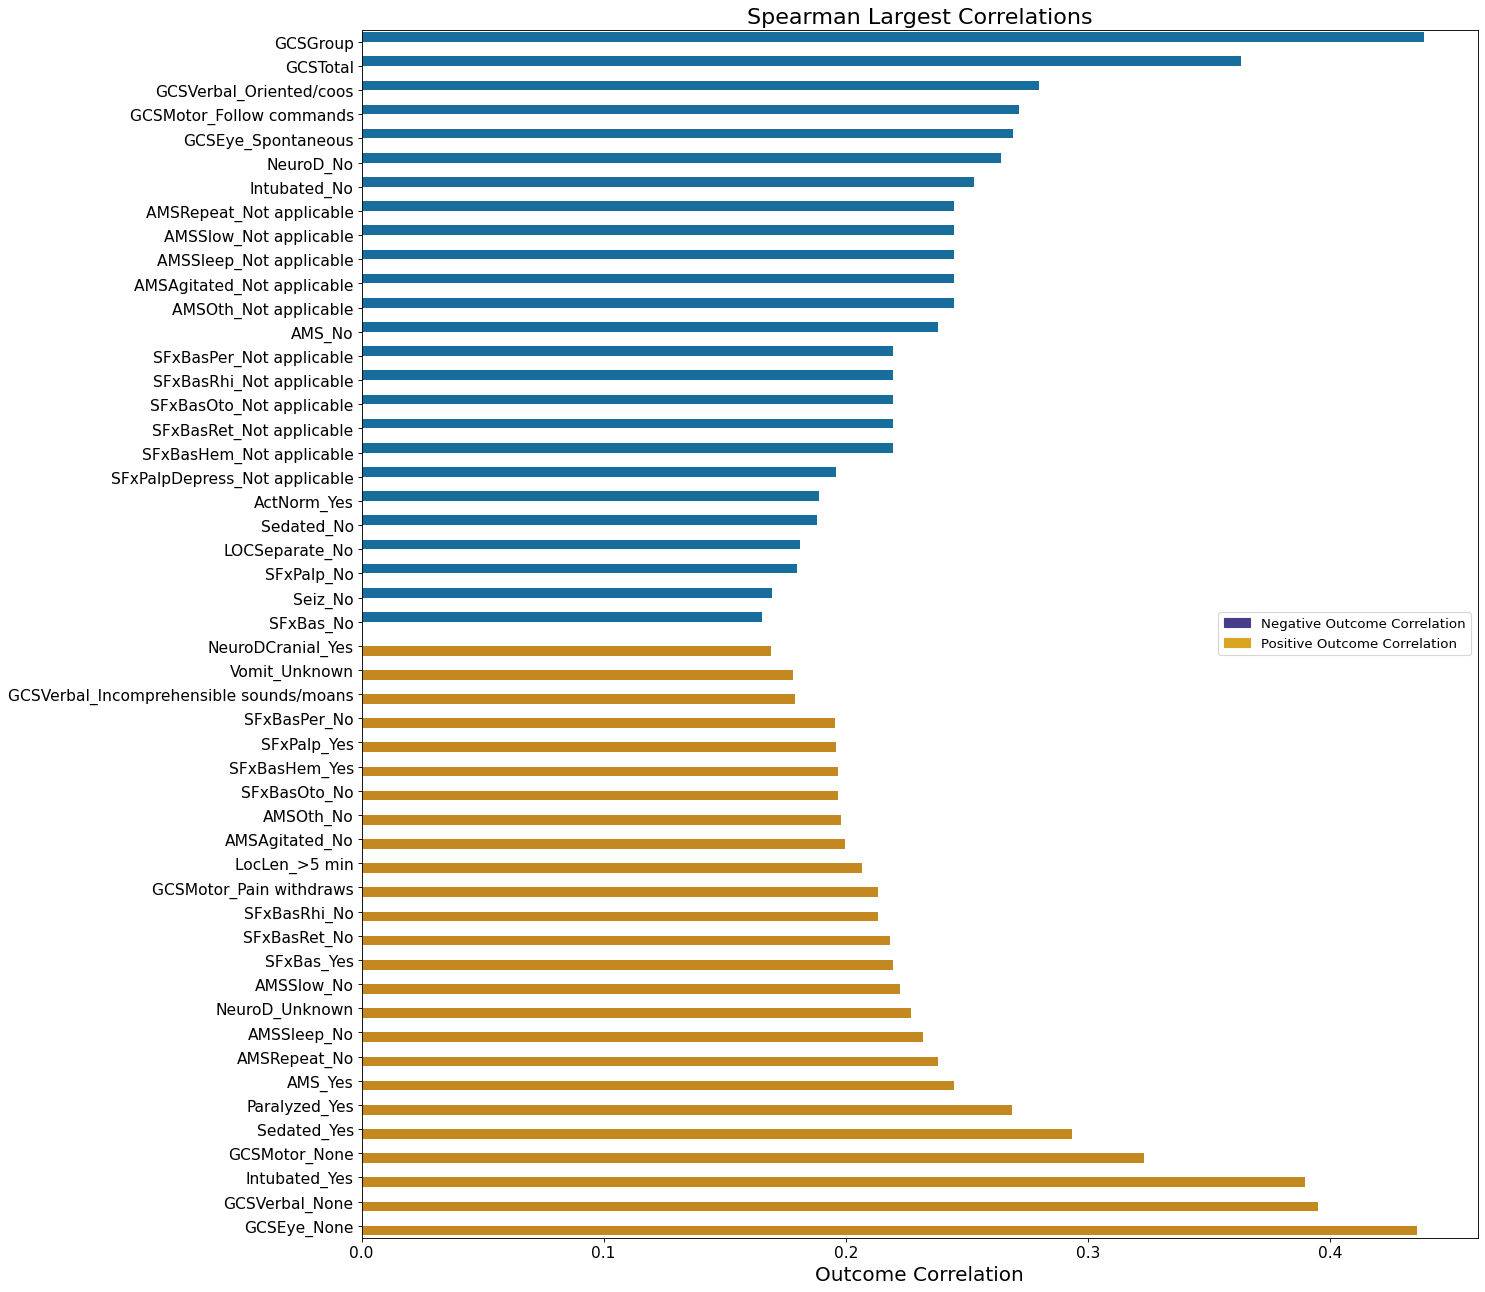

In [51]:
# remapping binary variables
bool_cols = [col for col in df1 if np.isin(df1[col].unique(), ['No', 'Yes']).all()]
for bool_col in bool_cols:
    df1[bool_col] = df1[bool_col].map({'No': 0, 'Yes': 1})

# one hot encoding the df
one_hot_df = helper.one_hot_encode_df(df1)
corr = one_hot_df.drop(['outcome'], axis=1).apply(lambda x: x.corr(one_hot_df['outcome'], method='spearman'))

# sortest by largest value
largest_corr = corr.iloc[corr.abs().argsort()][-50:].sort_values(ascending=True)
graph.barplot(largest_corr, savefig=True, title=None, xlab='Outcome Correlation')

# sort by absolute value
abs_corr = corr.abs().sort_values(ascending=True)
fig_fcn = lambda kwargs: plt.figure(figsize=(18, 20), **kwargs)
fig_fcn({"num": None, "dpi": 80, "facecolor": "w", "edgecolor": "r"})
sns.barplot(x=abs_corr[largest_corr.index].values, y=abs_corr[largest_corr.index].index, hue=[1 if corr > 0 else 0 for corr in largest_corr.values], palette='colorblind')
handles = [mpl.patches.Patch(color='darkslateblue', label='Negative Outcome Correlation'), mpl.patches.Patch(color='goldenrod', label='Positive Outcome Correlation')]
plt.legend(handles=handles, loc='center right')
plt.title('Spearman Largest Correlations')
plt.xlabel('Outcome Correlation')

Here I would like to meander around the GCS metrics to resolve what to do for preprocessing. My initial thought process was that increasing the age would increase the likelihood of more accurate GCS scores - long story short, I was wrong. On a similar note, the clinician believed that unknowns were proxies for just normal kids, but GCSVerbal and GCSMotor with unknowns had a much larger correlation to ciTBI, the outcome, and the means of the GCSTotal scores were lower with unknown scores. My thought from plotting and analyzing the empirical distributions is to do the contrary and instead impute this as if the patient were not well. This is a judgement call - the alternatives are really: 1) impute patient as normal, 2) remove patient altogether, 3) do nothing, or maybe 4) impute according to mean/median which IMO aren't better if we trust the data itself (not sure). I am more tempted to actually just remove these categorical ones - GCSEye, GCSVerbal, and GCSMotor and instead rely on the GCSTotal as none are missing and the ones with missing subcategories - Eye/Verbal/Motor - happened to still have GCSTotal. 

Text(0, 0.5, 'Count')

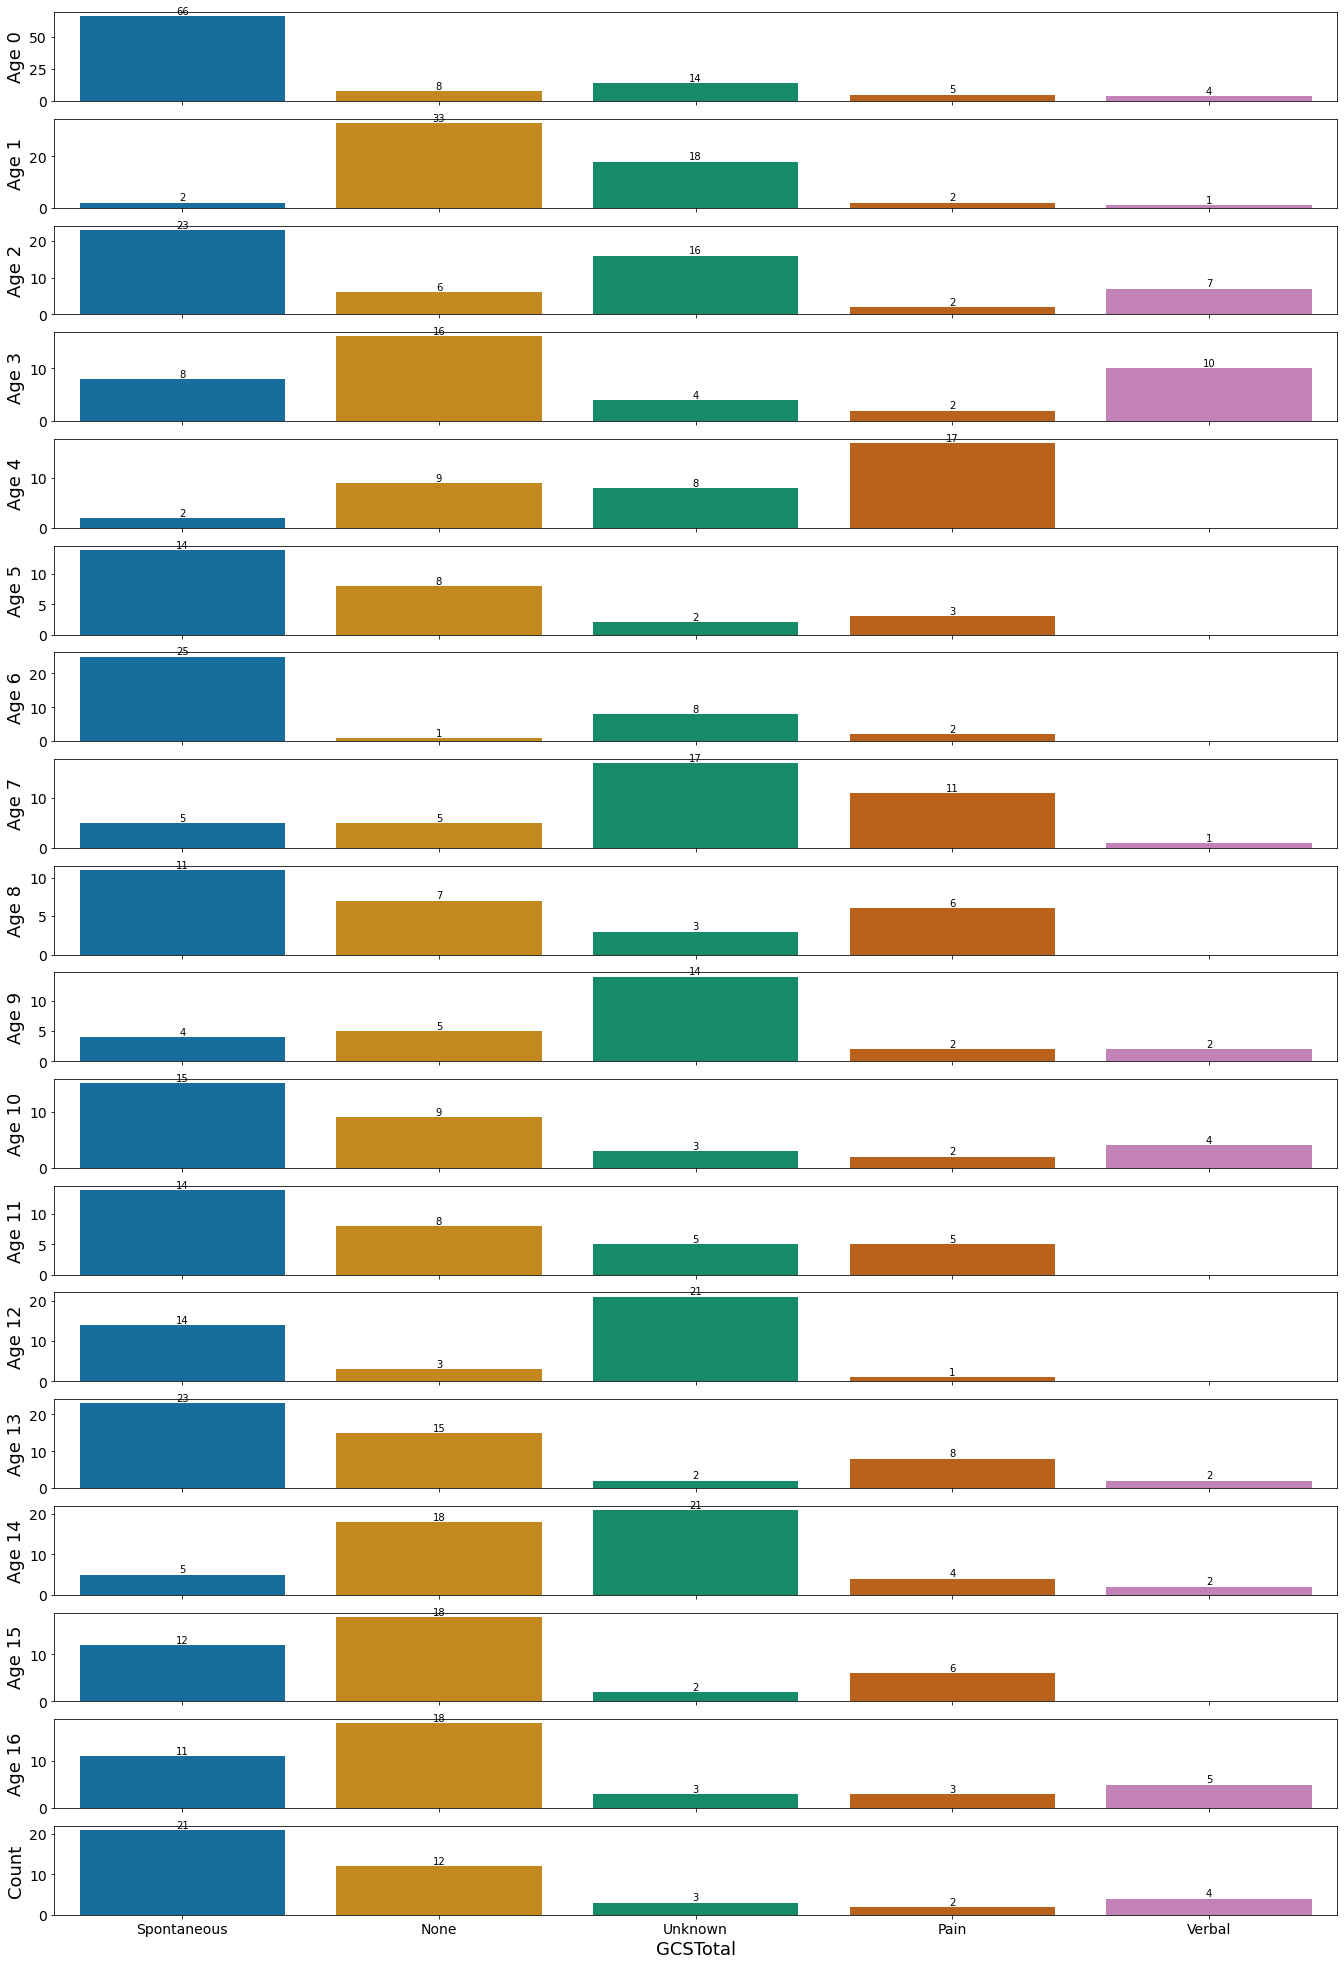

In [658]:
# GCS score plots
fig, axs = plt.subplots(nrows=18, sharex=True,  figsize=(23,35))
for i in range(18):
    sns.countplot(x='GCSEye', data=df[(df['AgeinYears'] == i) & (df['outcome'] == 'Yes')], ax=axs[i], palette="colorblind")
    axs[i].set_ylabel(f'Age {i}')
    axs[i].set_xlabel('')
    axs[i].bar_label(axs[i].containers[0])
    if i == 17:
        axs[i].set_xlabel('GCSTotal')
        
plt.ylabel('Count')

In [648]:
df[(df['outcome'] == 'Yes') & (df['GCSVerbal'] == 'Unknown')]['GCSTotal'].describe()

count    36.000000
mean      8.500000
std       5.140873
min       3.000000
25%       3.000000
50%       8.000000
75%      14.000000
max      15.000000
Name: GCSTotal, dtype: float64

Now we plot the distributions of some of the features with the most correlated encodings:

Text(0.5, 137.00000000000043, 'Count')

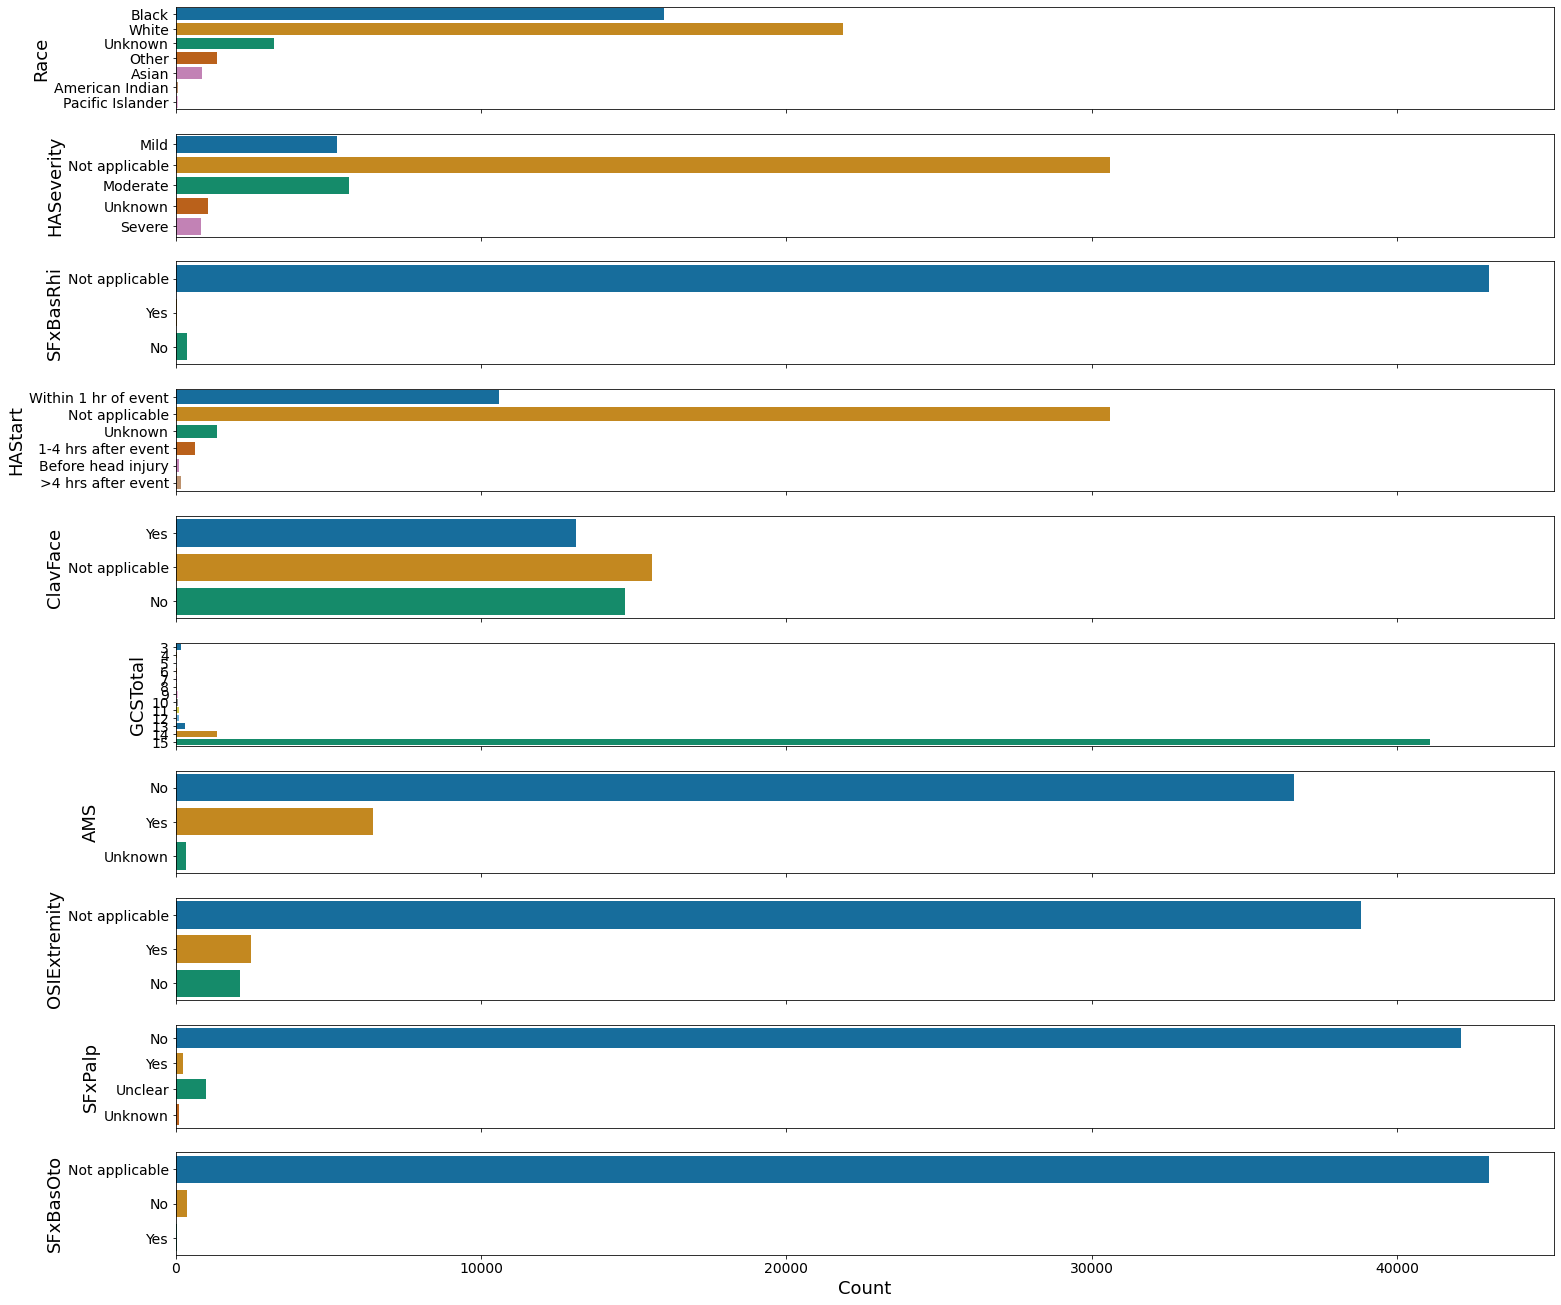

In [735]:
plot_count = 10
correlated_feats = list(set([feat.split('_')[0] for feat in abs_corr.index.tolist()]))
fig, axs = plt.subplots(nrows=plot_count, sharex=True,  figsize=(20,18))
fig.tight_layout()
for i in range(plot_count):
    sns.countplot(y=correlated_feats[i], data=df, ax=axs[i], palette="colorblind")
    axs[i].set_xlabel('')
plt.xlabel('Count')

Code below takes to long to run as there are too many features at the moment. It simply displays the correlation heatmap... Instead we can skip over this and perform PCA on the one-hot-encoded data to maybe condense our space.

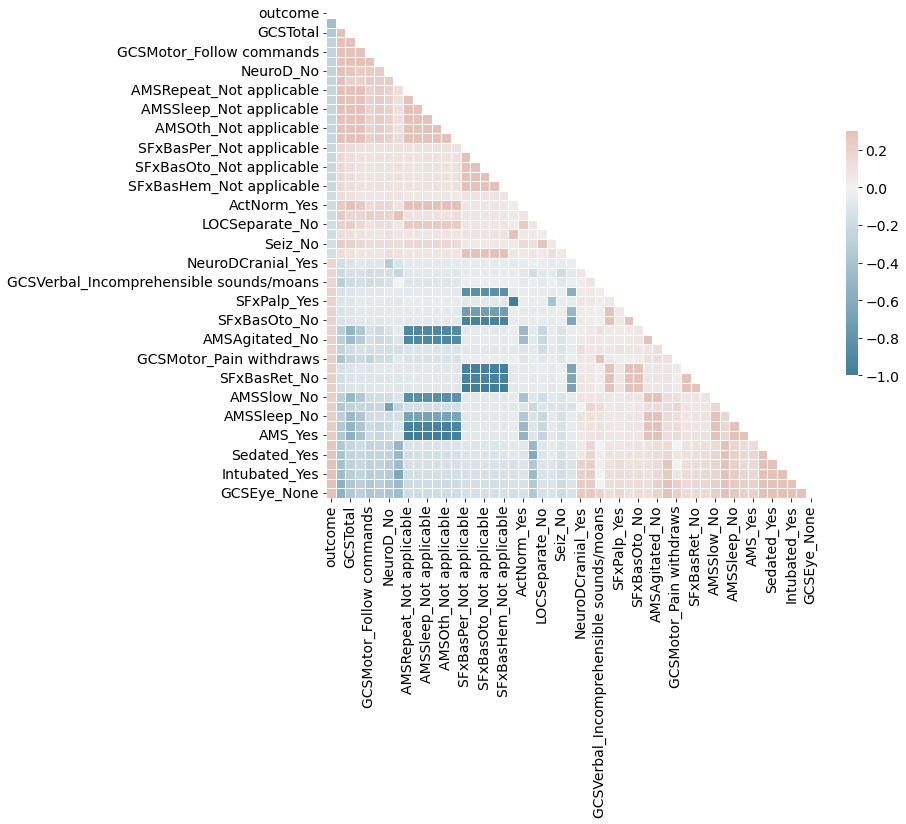

In [52]:
# plotting correlation of most positively correlated features to outcome
corr = one_hot_df[['outcome'] + largest_corr.index.tolist()].corr(method='kendall')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig("figs/" + f"heatmap.png", dpi=350, bbox_inches='tight')

## Variable Transformations
In this section, I would like to test if the distributions of outcomes are the same for the categories say >15min, 1-5min, etc. for SeizLen, LocLen, etc. is justified by looking at the 2-sample Kolmogorov Smirnov test. The goal of course is just sensical dimension reduction.

The features in question are: High_impact_InjSev, LocLen, SeizOccur, SeizLen, HASeverity, HAStart, VomitNbr, VomitStart, VomitLast, HemaLoc, and HemaSize.

In [27]:
from scipy.stats import ks_2samp
from itertools import permutations

# remapping binary variables
bool_cols = [col for col in df if np.isin(df[col].unique(), ['No', 'Yes']).all()]
for bool_col in bool_cols:
    df[bool_col] = df[bool_col].map({'No': 0, 'Yes': 1})
    
suspect_vars = ['High_impact_InjSev', 'LocLen', 'SeizOccur', 'SeizLen', 'HASeverity',
               'HAStart', 'VomitNbr', 'VomitStart', 'VomitLast', 'HemaLoc', 'HemaSize']

def ks_test(df, feature, p_tol):
    print(f'Test for feature {feature}:\n')
    categories = df[feature].unique()
    for i in range(len(categories)):
        for j in range(i + 1, len(categories)):
            x = df[df[feature] == categories[i]]['outcome']
            y = df[df[feature] == categories[j]]['outcome']
            p_val = ks_2samp(x, y)[1]
            if p_val <= p_tol:
                print(f'{categories[i]} and {categories[j]} have different distributions.')
            else:
                print(f'{categories[i]} and {categories[j]} have the same distribution.')

    print('\n')
            
for var in suspect_vars:
    ks_test(df, var, 0.05)

Test for feature High_impact_InjSev:

Moderate and Low have the same distribution.
Moderate and Unknown have the same distribution.
Moderate and High have different distributions.
Low and Unknown have the same distribution.
Low and High have different distributions.
Unknown and High have the same distribution.


Test for feature LocLen:

Not applicable and 1-5 min have the same distribution.
Not applicable and 5 sec - 1 min have the same distribution.
Not applicable and Unknown have different distributions.
Not applicable and <5 sec have the same distribution.
Not applicable and >5 min have different distributions.
1-5 min and 5 sec - 1 min have the same distribution.
1-5 min and Unknown have the same distribution.
1-5 min and <5 sec have the same distribution.
1-5 min and >5 min have different distributions.
5 sec - 1 min and Unknown have different distributions.
5 sec - 1 min and <5 sec have the same distribution.
5 sec - 1 min and >5 min have different distributions.
Unknown and <5 

In summary,
* High_impact_InjSev -> (low and moderate) versus high (not sure about unknowns)
* LocLen -> (<5 sec, 5 sec - 1 min, 1-5 min, not applicable) versus >5 min (not sure about unknowns)
* SeizOccur -> all have the same distribution (except unknowns) so probably not useful
* SeizLen -> (<1 min, 1-5 min, 5-15 min, not applicable) versus >15 min (maybe) and not sure about unknowns
* HASeverity -> all have the same distribution
* HAStart -> all have the same distribution
* VomitNbr -> all have the same distribution, not sure about unknowns
* VomitStart -> all have the same distribution
* VomitLast -> all have the same distribution, not sure about unknowns
* HemaLoc -> parietal/temporal versus (frontal, occipital, not applicable), not sure about unknowns
* HemaSize -> large versus (small, medium, not applicable), not sure about unknowns

# PCA Analysis
@Hyunsuk

In [12]:
# Temporary #####
filename = "../../../../data/tbi_pecarn/raw/TBI PUD 10-08-2013.csv"
data = pd.read_csv(filename)
#################

In [43]:
# Some preprocessing - should be updated in clean_data later
# Grouped variables NA -> NO

data['AMSAgitated'] = data['AMSAgitated'].apply(lambda x : 0 if(x == 92) else x)
data['AMSSleep'] = data['AMSSleep'].apply(lambda x : 0 if(x == 92) else x)
data['AMSSlow'] = data['AMSSlow'].apply(lambda x : 0 if(x == 92) else x)
data['AMSRepeat'] = data['AMSRepeat'].apply(lambda x : 0 if(x == 92) else x)
data['AMSOth'] = data['AMSOth'].apply(lambda x : 0 if(x == 92) else x)

data['SFxBasHem'] = data['SFxBasHem'].apply(lambda x : 0 if(x == 92) else x)
data['SFxBasOto'] = data['SFxBasOto'].apply(lambda x : 0 if(x == 92) else x)
data['SFxBasPer'] = data['SFxBasPer'].apply(lambda x : 0 if(x == 92) else x)
data['SFxBasRet'] = data['SFxBasRet'].apply(lambda x : 0 if(x == 92) else x)
data['SFxBasRhi'] = data['SFxBasRhi'].apply(lambda x : 0 if(x == 92) else x)

data['ClavFace'] = data['ClavFace'].apply(lambda x : 0 if(x == 92) else x)
data['ClavNeck'] = data['ClavNeck'].apply(lambda x : 0 if(x == 92) else x)
data['ClavFro'] = data['ClavFro'].apply(lambda x : 0 if(x == 92) else x)
data['ClavOcc'] = data['ClavOcc'].apply(lambda x : 0 if(x == 92) else x)
data['ClavPar'] = data['ClavPar'].apply(lambda x : 0 if(x == 92) else x)
data['ClavTem'] = data['ClavTem'].apply(lambda x : 0 if(x == 92) else x)

data['NeuroD'] = data['NeuroD'].apply(lambda x : 0 if(x == 92) else x)
data['NeuroDMotor'] = data['NeuroDMotor'].apply(lambda x : 0 if(x == 92) else x)
data['NeuroDSensory'] = data['NeuroDSensory'].apply(lambda x : 0 if(x == 92) else x)
data['NeuroDCranial'] = data['NeuroDCranial'].apply(lambda x : 0 if(x == 92) else x)
data['NeuroDReflex'] = data['NeuroDReflex'].apply(lambda x : 0 if(x == 92) else x)
data['NeuroDOth'] = data['NeuroDOth'].apply(lambda x : 0 if(x == 92) else x)

data['OSIExtremity'] = data['OSIExtremity'].apply(lambda x : 0 if(x == 92) else x)
data['OSICut'] = data['OSICut'].apply(lambda x : 0 if(x == 92) else x)
data['OSICspine'] = data['OSICspine'].apply(lambda x : 0 if(x == 92) else x)
data['OSIFlank'] = data['OSIFlank'].apply(lambda x : 0 if(x == 92) else x)
data['OSIAbdomen'] = data['OSIAbdomen'].apply(lambda x : 0 if(x == 92) else x)
data['OSIPelvis'] = data['OSIPelvis'].apply(lambda x : 0 if(x == 92) else x)
data['OSIOth'] = data['OSIOth'].apply(lambda x : 0 if(x == 92) else x)

data['IndAge'] = data['IndAge'].apply(lambda x : 0 if(x == 92) else x)
data['IndAmnesia'] = data['IndAmnesia'].apply(lambda x : 0 if(x == 92) else x)
data['IndAMS'] = data['IndAMS'].apply(lambda x : 0 if(x == 92) else x)
data['IndClinSFx'] = data['IndClinSFx'].apply(lambda x : 0 if(x == 92) else x)
data['IndHA'] = data['IndHA'].apply(lambda x : 0 if(x == 92) else x)
data['IndHema'] = data['IndHema'].apply(lambda x : 0 if(x == 92) else x)
data['IndLOC'] = data['IndLOC'].apply(lambda x : 0 if(x == 92) else x)
data['IndMech'] = data['IndMech'].apply(lambda x : 0 if(x == 92) else x)
data['IndNeuroD'] = data['IndNeuroD'].apply(lambda x : 0 if(x == 92) else x)
data['IndRqstMD'] = data['IndRqstMD'].apply(lambda x : 0 if(x == 92) else x)
data['IndRqstParent'] = data['IndRqstParent'].apply(lambda x : 0 if(x == 92) else x)
data['IndRqstTrauma'] = data['IndRqstTrauma'].apply(lambda x : 0 if(x == 92) else x)
data['IndSeiz'] = data['IndSeiz'].apply(lambda x : 0 if(x == 92) else x)
data['IndVomit'] = data['IndVomit'].apply(lambda x : 0 if(x == 92) else x)
data['IndXraySFx'] = data['IndXraySFx'].apply(lambda x : 0 if(x == 92) else x)
data['IndOth'] = data['IndOth'].apply(lambda x : 0 if(x == 92) else x)

df = data
df=df.rename(columns = {'PosIntFinal':'outcome'})

In [46]:
data2.columns

Index(['EmplType', 'Certification', 'InjuryMech', 'High_impact_InjSev',
       'Amnesia_verb', 'LOCSeparate', 'LocLen', 'Seiz', 'SeizOccur', 'SeizLen',
       'ActNorm', 'HA_verb', 'HASeverity', 'HAStart', 'Vomit', 'VomitNbr',
       'VomitStart', 'VomitLast', 'Intubated', 'Paralyzed', 'Sedated',
       'GCSEye', 'GCSVerbal', 'GCSMotor', 'GCSTotal', 'GCSGroup', 'AMS',
       'AMSAgitated', 'AMSSleep', 'AMSSlow', 'AMSRepeat', 'AMSOth', 'SFxPalp',
       'SFxPalpDepress', 'FontBulg', 'SFxBas', 'SFxBasHem', 'SFxBasOto',
       'SFxBasPer', 'SFxBasRet', 'SFxBasRhi', 'Hema', 'HemaLoc', 'HemaSize',
       'Clav', 'ClavFace', 'ClavNeck', 'ClavFro', 'ClavOcc', 'ClavPar',
       'ClavTem', 'NeuroD', 'NeuroDMotor', 'NeuroDSensory', 'NeuroDCranial',
       'NeuroDReflex', 'NeuroDOth', 'OSI', 'OSIExtremity', 'OSICut',
       'OSICspine', 'OSIFlank', 'OSIAbdomen', 'OSIPelvis', 'OSIOth', 'Drugs',
       'IndAge', 'IndAmnesia', 'IndAMS', 'IndClinSFx', 'IndHA', 'IndHema',
       'IndLOC', 'IndMech', '

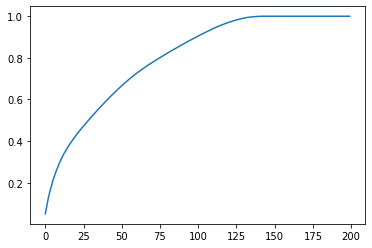

In [45]:
data1 = df.drop(['Race', 'Observed', 'Ethnicity', 'Dizzy', 
                 #'IndAge', 'IndAmnesia', 'IndAMS', 'IndClinSFx', 'IndHA', 'IndHema', 'IndLOC',
                 #'IndMech', 'IndNeuroD', 'IndRqstMD', 'IndRqstParent', 'IndRqstTrauma', 'IndSeiz', 
                 #'IndVomit', 'IndXraySFx', 'IndOth',
                 'CTForm1', 'CTSed', 'CTSedAgitate', 'CTSedAge', 'CTSedRqst', 'CTSedOth'], axis = 1).dropna()

data2 = data1.iloc[:,1:88]
data2_age = data2[['AgeInMonth', 'AgeinYears']]
data2_noage = data2.drop(['AgeInMonth', 'AgeinYears'], axis = 1)   # Categorical Outcomes

# One-hot encoding
data3 = pd.get_dummies(data2_noage, columns = list(data2_noage.columns))
data4 = pd.concat([data3, data2_age], axis=1)   # (28861, 245)

data4_scaled = StandardScaler().fit_transform(data4)

# Conducting PCA 
pca = PCA().fit(data4_scaled) 
explained_variance = np.copy(pca.explained_variance_ratio_)
explained_variance_sum = explained_variance

# Variance explained
for i in range(1, len(explained_variance_sum)) :
    explained_variance_sum[i] += explained_variance_sum[i-1] 

# Scree Plot
plt.plot(explained_variance_sum[0:200])

# PC Scores
pc_score = pca.transform(data4_scaled)


# Outcome of each patients (to color, size the scatter plot below)
posint_col = np.where(data1['outcome'] == 1, '#ff0f0e', '#1f77b4')
posint_sz = np.where(data1['outcome'] == 1, 7, 0.7)



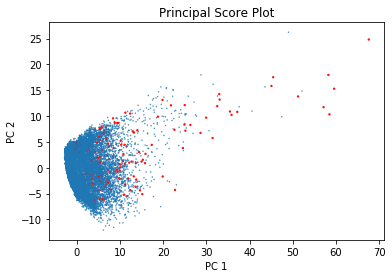

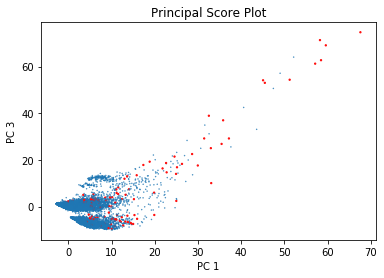

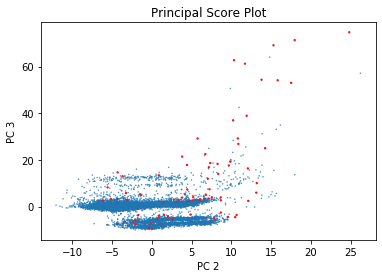

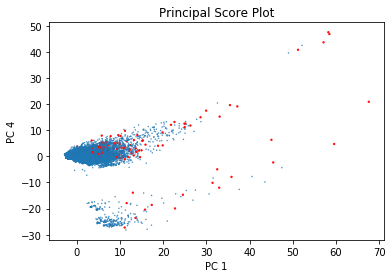

In [47]:

# PC PLOT 1 2(RED DOTS : PosIntFinal == 1)  
# THIS PART SHOULD BE CHANGED INTO A FUNCTION LATER
# Total : 28223 / PosIntFinal == 1 : 160
plt.figure()
plt.title("Principal Score Plot")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.scatter(pc_score[:,0], pc_score[:,1], c = posint_col, s = posint_sz, alpha = 1, marker = '.')

# PC PLOT 1 3
plt.figure()
plt.title("Principal Score Plot")
plt.xlabel("PC 1")
plt.ylabel("PC 3")
plt.scatter(pc_score[:,0], pc_score[:,2], c = posint_col, s = posint_sz, alpha = 1, marker = '.')

# PC PLOT 2 3
plt.figure()
plt.title("Principal Score Plot")
plt.xlabel("PC 2")
plt.ylabel("PC 3")
plt.scatter(pc_score[:,1], pc_score[:,2], c = posint_col, s = posint_sz, alpha = 1, marker = '.')


# PC PLOT 1 4
plt.figure()
plt.title("Principal Score Plot")
plt.xlabel("PC 1")
plt.ylabel("PC 4")
plt.scatter(pc_score[:,0], pc_score[:,3], c = posint_col, s = posint_sz, alpha = 1, marker = '.')

In [60]:
# Lastly, let's see what contributes to PC3 (3 Groups), PC4 (2 Groups) the most
print(data4.columns[np.where(pca.components_[0,:] > 0.145, True, False)]) # - Related to Acting normally, AMS (Altered Mental Status)
print(data4.columns[np.where(pca.components_[1,:] > 0.2, True, False)]) # - Related to Age (< 2 or pre-verbal)

print(data4.columns[np.where(pca.components_[2,:] > 0.2, True, False)]) # - Related to Vomit
print(data4.columns[np.where(pca.components_[3,:] > 0.2, True, False)]) # - Related to Seize

print(data4.columns[np.where(pca.components_[4,:] > 0.15, True, False)]) # - Related to Intubted, Paralyzed, GCS scores
print(data4.columns[np.where(pca.components_[5,:] > 0.15, True, False)]) # - Related to Hematoma or swelling
print(data4.columns[np.where(pca.components_[6,:] > 0.2, True, False)]) # - Related to Neurological Deficit
print(data4.columns[np.where(pca.components_[7,:] > 0.2, True, False)]) # - Related to Neurological Deficit


# Checking the PC loading
pc_which = 7
pca.components_[pc_which, np.where(pca.components_[pc_which,:] > 0.1, True, False)]

Index(['ActNorm_0.0', 'AMS_1.0'], dtype='object')
Index(['Amnesia_verb_91.0', 'HA_verb_91.0', 'HASeverity_92.0', 'HAStart_92.0',
       'AgeTwoPlus_1'],
      dtype='object')
Index(['Vomit_0.0', 'VomitNbr_92.0', 'VomitStart_92.0', 'VomitLast_92.0'], dtype='object')
Index(['Seiz_0.0', 'SeizOccur_92.0', 'SeizLen_92.0', 'IndSeiz_0'], dtype='object')
Index(['Intubated_1.0', 'Paralyzed_1.0', 'GCSEye_1.0', 'GCSVerbal_1.0',
       'GCSMotor_1.0', 'GCSTotal_3', 'Hema_0.0', 'HemaLoc_92.0',
       'HemaSize_92.0'],
      dtype='object')
Index(['Hema_1.0', 'HemaLoc_1.0', 'HemaSize_2.0'], dtype='object')
Index(['NeuroD_0.0'], dtype='object')
Index(['NeuroD_0.0', 'NeuroDOth_0', 'IndNeuroD_0'], dtype='object')


array([0.10896992, 0.16718077, 0.19189479, 0.11220886, 0.10624327,
       0.17385364, 0.17984361, 0.25136806, 0.10010508, 0.10221751,
       0.2049555 , 0.13918213, 0.11699308, 0.11699758, 0.2081134 ])

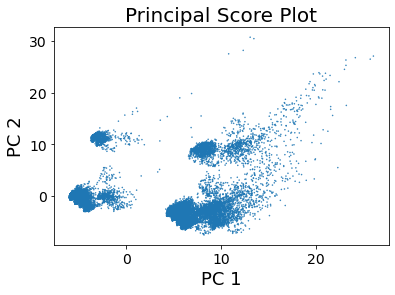

In [461]:
# CTForm1 (CT was ordered or not) contributes the most to PC1 

# How many of them were YES (CT was ordered)
sum(data1['CTForm1'] == 1)  # 8031 / 28223

# Indicating CTForm1 = Yes as red
ctform_col = np.where(data1['CTForm1'] == 1, '#ff0f0e', '#1f77b4')

plt.figure()
plt.title("Principal Score Plot")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.scatter(pc_score[:,0], pc_score[:,1], c = ctform_col, s = 1, alpha = 1, marker = '.')

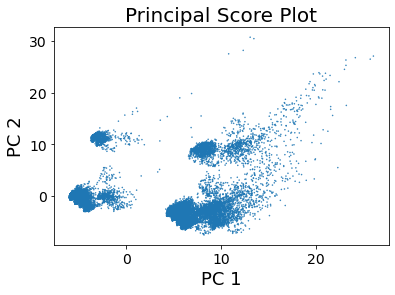

In [462]:
# OSI (other ) contributes the most to PC2

# How many of them were YES 
sum(data1['OSI'] == 1)  # 2191 / 28223

# Indicating OSI = Yes as red
osi_col = np.where(data1['OSI'] == 1, '#ff0f0e', '#1f77b4')

plt.figure()
plt.title("Principal Score Plot")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.scatter(pc_score[:,0], pc_score[:,1], c = osi_col, s = 1, alpha = 1, marker = '.')